In [6]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt


## Clase City:

Se define la clase city con los siguientes métodos y atributos. 

Atributos: 
+ x: variable que almacena la coordenada x del punto. 
+ y: variable que almacena la coordenada y del punto. 

Métodos:
+ distance(): recibe un objeto de tipo city, calcula la distancia del punto actual y el que se recibió, posteriormente retorna esta distancia.



In [7]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


## Clase Fitness

Se define la clase fitness con los siguientes métodos y atributos. 

Atributos: 
+ rute: parámetro de entrada en el constructor, recibe la ruta que tiene un individuo. 
+ distance: variable que almacena la distancia total de la ruta
+ fitness: variable que almacena el rendimiento del individuo.

Métodos:
+ routeDistance(): calcula la distancia total de la ruta, posteriormente almacena y retorna dicho valor en la variable distance.
+ routeFitness(): calcula el fitness del individuo, este se establece como 1/distancia, retorna y almacena el valor en la variable fitness.



In [8]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


## Funciones del Algoritmo Genético

### createRoute()
Entrada: Lista de ciudades.

Se recibe como parámetro la lista de ciudades y posteriormente se crean rutan de forma aleatoria, siempre dejando la primera ciudad como punto de inicio. 

Salida: ruta generada.

In [9]:
def createRoute(cityList):
    route=random.sample(cityList[1:], len(cityList)-1)
    route.insert(0, cityList[0])
    # route = random.sample(cityList, len(cityList))
    return route


### initialPopulation()
Entrada: tamaño de población, lista de ciudades.

Dependiendo el tamaño de población agregamos y asignamos rutas a cada individuo.

Salida: población

In [10]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


### rankRoutes()
Entrada: población

Se itera sobre la población y se calcula el fitness de cada individuo. Posteriormente se ordenan por fitness. 

Salida: población ordenada por fitness


In [11]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


### selection()
Entrada: población ordenada y tamaño de población élite.

Se agregan directamente la población elite a la lista de seleccionados, posteriormente de manera aleatoria se van agregando el resto de los individuos. 

Salida: lista con los individuos seleccionados. 

In [12]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults


## matingPool()
Entrada: población, resultados de selección


Salida: Lista de apareamiento

In [13]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


## breed()
Entrada: dos individuos que actuarán como padres.

De forma aleatoria se seleccionan partes de la ruta(gen) de cada uno de los padres, se agregan y posteriormente si cierta ciudad no se encuentra se agregan del otro padre.

Salida: nuevo individuo

In [14]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


### breedPopulation()
Entrada: lista de apareamiento, tamaño de elite

Dependiendo el tamaño de la población elite, iteramos sobre ella y se agrega a la lista de nuevos individuos, el resto de la población se cruza utilizando la función de breed()

Salida: Lista de nuevos individuos


In [15]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


### mutate(): 

Entrada: individuo

Se aplica el algoritmo 2opt como una mutación a la ruta(gen) del individuo. 

salida: individuo mutado.

In [16]:
def mutate(individual):
    best = individual
    improved = True
    n = len(individual)
    while improved:
            improved = False
            for i in range(1, n-1):
                for j in range(i+1, n-1):
                    if j-i == 1:
                        continue
                    new_individual = individual[:]
                    # this is the 2woptSwap
                    new_individual[i:j] = individual[j-1:i-1:-1]
                    if Fitness(new_individual).routeDistance() < Fitness(best).routeDistance():
                        best = new_individual
                        improved = True
    individual = best
    return best


# mutatepopulation()

Entrada: población

se itera sobre la población y se realiza la operación de mutación con la función mutate.

Salida: población mutada.

In [17]:
def mutatePopulation(population):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind])
        mutatedPop.append(mutatedInd)
    return mutatedPop


### nextGeneration()
Entrada: generacionactual y tamaño de elite

Se encarga de realizar el cambio generacional utilizando las funciones previamente descritas


Salida: Nueva generación

In [18]:
def nextGeneration(currentGen, eliteSize):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children)
    return nextGeneration


### geneticAlgorithm()
Entrada:
+ población
+ tamaño de población
+ tamaño de elite
+ total de generaciones

inicializa la población inicial, y calcula el fitness del mejor individuo, posteriormente itera sobre la el total de generaciones, evaluando y haciendo nuevas generaciones. Imprimiendo en cada iteración el progreso.


Salida: ruta optima


In [19]:
def geneticAlgorithm(population, popSize, eliteSize, generations):
    pop = initialPopulation(popSize, population)
    progress = []

    distance = (1 / rankRoutes(pop)[0][1])
    progress.append(distance)
    print(f"Initial distance:   {distance}")
    
    # Best first route
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    # print(bestRoute)
    plotRoute(bestRoute, "Best Initial Route")




    for i in range(0, generations):
        print(f"Current gen {i}")
        pop = nextGeneration(pop, eliteSize)
        progress.append(1 / rankRoutes(pop)[0][1])
        print(f"current best : {1 / rankRoutes(pop)[0][1]}")


    # Best final route.
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plotRoute(bestRoute, "Best Found Route")


    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

    return bestRoute




In [35]:
def plotRoute(bestRoute, title=""):
    bestRoute.append(bestRoute[0])
    bestRoute = np.array([list([i.x, i.y])for i in bestRoute])

    # plot best initial route
    plt.plot(bestRoute[:,0], bestRoute[:,1], marker='o')
    plt.title(title)
    plt.show()

## Prueba con datos aleatorios

Se agregan 50 objetos City a la lista de ciudades. Y posteriormente se invoca la función del algoritmo genético. 

In [36]:
cityList = []

for i in range(0, 50):
    cityList.append(City(x=int(random.random() * 200),
                    y=int(random.random() * 200)))


Initial distance:   4602.9155824704585


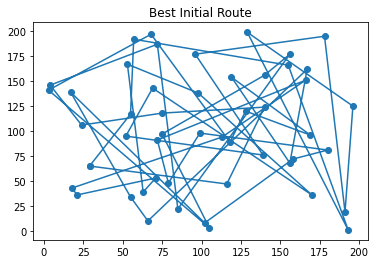

Current gen 0
current best : 4285.623365931734
Current gen 1
current best : 4040.381039279748
Current gen 2
current best : 3750.5307978656438
Current gen 3
current best : 3531.7921224727893
Current gen 4
current best : 3346.7784132439956
Current gen 5
current best : 3177.1007960076286
Current gen 6
current best : 3019.9565609763686
Current gen 7
current best : 2844.6184345555534
Current gen 8
current best : 2678.4159979838064
Current gen 9
current best : 2535.2706286142366
Current gen 10
current best : 2406.8216096257365
Current gen 11
current best : 2293.3687084569633
Current gen 12
current best : 2168.3946156434904
Current gen 13
current best : 2058.087659362176
Current gen 14
current best : 1967.4070016782082
Current gen 15
current best : 1879.9390281656015
Current gen 16
current best : 1793.8151645137657
Current gen 17
current best : 1712.7163073232398
Current gen 18
current best : 1667.580951364304
Current gen 19
current best : 1627.2861607329683
Current gen 20
current best : 1590

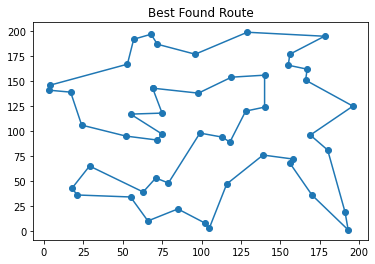

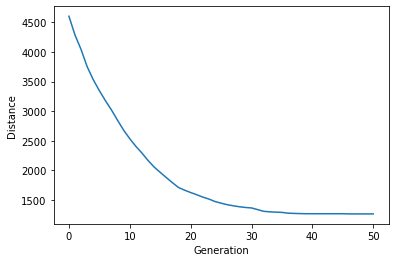

[(69,143),
 (98,138),
 (119,154),
 (140,156),
 (140,124),
 (128,120),
 (118,89),
 (113,94),
 (99,98),
 (79,48),
 (71,53),
 (63,39),
 (29,65),
 (18,43),
 (21,36),
 (55,34),
 (66,10),
 (85,22),
 (102,8),
 (105,3),
 (116,47),
 (139,76),
 (158,72),
 (156,68),
 (170,36),
 (193,1),
 (191,19),
 (180,81),
 (169,96),
 (196,125),
 (166,151),
 (167,162),
 (155,166),
 (156,177),
 (178,195),
 (129,199),
 (96,177),
 (72,187),
 (68,197),
 (57,192),
 (53,167),
 (4,146),
 (3,141),
 (17,139),
 (24,106),
 (52,95),
 (72,91),
 (75,97),
 (55,117),
 (75,118),
 (69,143)]

In [39]:
geneticAlgorithm(population=cityList, popSize=10,
                 eliteSize=5, generations=50)


# Benchmark Kroa 100
A continuación se cargan utilizando el paquete de pandas los datos del benchmark del agente viajero "Kroa100"

In [35]:
data = pd.read_csv('kroA100.tsp', skiprows=[0, 1, 2, 3, 4, 5],
                   header=None, sep=' ')[:-1]
tour = pd.read_csv('kroA100.opt.tour', skiprows=[0, 1, 2, 3, 4],
                   header=None, sep=' ')[:-1]

data=data.rename(columns={0:"ID",1:"x",2:"y"})
dx=data.x.values[[int(i)-1 for i in tour[0].values]]
dy=data.y.values[[int(i)-1 for i in tour[0].values]]

kroaRoute = []
for i in range(len(dx)):
    kroaRoute.append(City(dx[i], dy[i]))

kroaDistance = Fitness(kroaRoute).routeDistance()
KroaFitness = Fitness(kroaRoute).routeFitness()

print(f"Benchmark Distance: {kroaDistance}")

Benchmark Distance: 23655.336871800282


Text(0.5, 1.0, "Benchmark's Best Route")

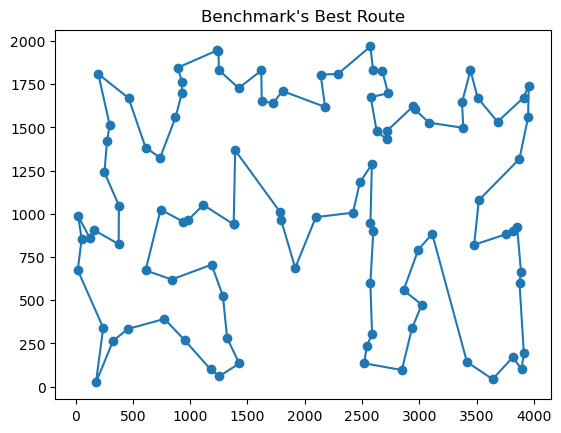

In [55]:
plt.plot(dx,dy, marker='o')
plt.title("Benchmark's Best Route")
plt.show()

In [34]:
cityList = [] 
for i in range (len (data.x.values)):
    cityList.append(City(data.x[i], data.y[i]))
ruta = createRoute(cityList)

Initial distance:   162079.66228568368


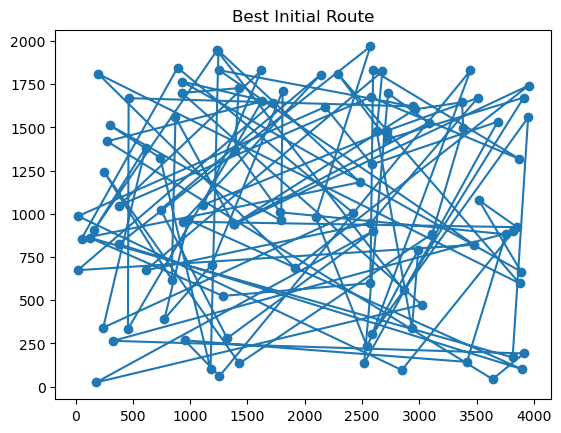

Current gen 0
current best : 155480.128631427
Current gen 1
current best : 147295.70873319148
Current gen 2
current best : 142363.0765710187
Current gen 3
current best : 137474.43981404242
Current gen 4
current best : 132502.28878261248
Current gen 5
current best : 127881.72960611165
Current gen 6
current best : 122602.6065101735
Current gen 7
current best : 115683.3378859532
Current gen 8
current best : 111352.08852739641
Current gen 9
current best : 107494.20612126461
Current gen 10
current best : 103748.58876863601
Current gen 11
current best : 99923.12874420502
Current gen 12
current best : 96453.32013535839
Current gen 13
current best : 92881.78995661701
Current gen 14
current best : 89957.23318401045
Current gen 15
current best : 86304.44420603082
Current gen 16
current best : 83589.82797131463
Current gen 17
current best : 80704.04720434554
Current gen 18
current best : 77707.8857585546
Current gen 19
current best : 75283.88621022455
Current gen 20
current best : 72994.283211161

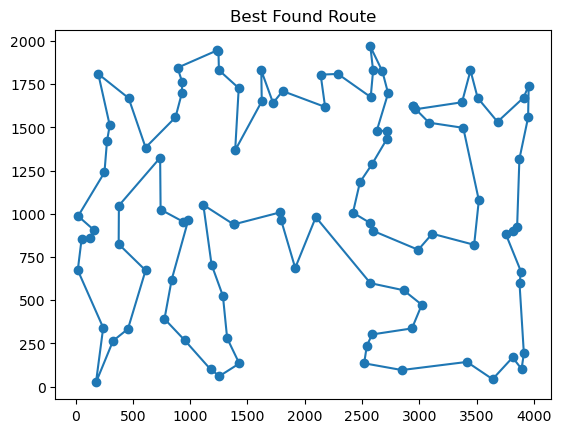

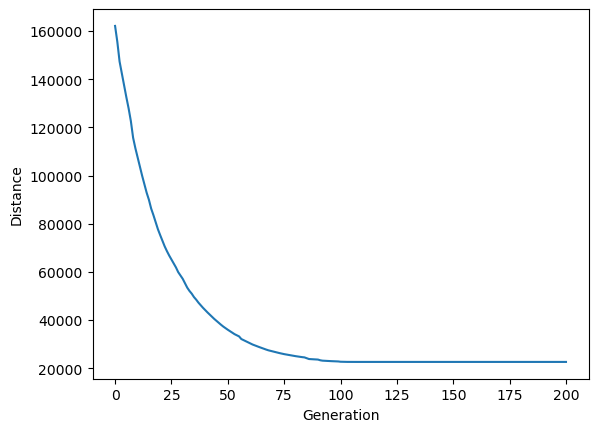

[(2945.0,1622.0),
 (3085.0,1528.0),
 (3384.0,1498.0),
 (3520.0,1079.0),
 (3479.0,821.0),
 (3113.0,885.0),
 (2991.0,792.0),
 (2599.0,901.0),
 (2574.0,946.0),
 (2421.0,1007.0),
 (2482.0,1183.0),
 (2586.0,1286.0),
 (2716.0,1432.0),
 (2721.0,1482.0),
 (2628.0,1479.0),
 (2728.0,1698.0),
 (2678.0,1825.0),
 (2573.0,1969.0),
 (2597.0,1830.0),
 (2576.0,1676.0),
 (2290.0,1810.0),
 (2139.0,1806.0),
 (2178.0,1619.0),
 (1807.0,1711.0),
 (1724.0,1642.0),
 (1621.0,1830.0),
 (1625.0,1651.0),
 (1393.0,1368.0),
 (1424.0,1728.0),
 (1251.0,1832.0),
 (1247.0,1945.0),
 (1234.0,1946.0),
 (890.0,1846.0),
 (929.0,1766.0),
 (928.0,1700.0),
 (872.0,1559.0),
 (611.0,1384.0),
 (463.0,1670.0),
 (198.0,1810.0),
 (298.0,1513.0),
 (274.0,1420.0),
 (252.0,1240.0),
 (22.0,987.0),
 (161.0,906.0),
 (123.0,862.0),
 (53.0,857.0),
 (19.0,674.0),
 (241.0,341.0),
 (178.0,24.0),
 (327.0,265.0),
 (457.0,334.0),
 (611.0,673.0),
 (376.0,825.0),
 (378.0,1048.0),
 (738.0,1325.0),
 (742.0,1025.0),
 (938.0,955.0),
 (984.0,965.0),
 (83

In [61]:
geneticAlgorithm(population=cityList, popSize=10,
                 eliteSize=5, generations=200)

#### Observaciones.  

+ En la gráfica de la ruta óptima encontrada se puede ver que el algoritmo 2OPT logró eliminar de manera satisfactoria loos cruces dentro de la ruta. 
+ En la gráfica de distancia y generación se puede apreciar como de forma suave y constante se va reduciendo el costo hasta que cerca de la generación 100 se el proceso convergió.


# Conclusiones: 

Se puede observar que el uso de algoritmos genéticos al problema del agente viajero (TSP) es una forma en la que se puede obtener una ruta optima mediante la exploración aleatoria que naturalmente está presente en ellos. Podemos además observar que implementar el algoritmo de 2-OPT como mecanismo de mutación es efectivo al eliminar correctamente los cruces que pueden estar presentes en la ruta. Ayudando a reducir el costo o distancia del recorrido.

Una desventaja que presentan es el tiempo de ejecución, ya que debemos iterar entre toda la población y las generaciones. 

#### ¿Posibles mejoras?

+ Iniciar las rutas con un enfoque codicioso (vecinos más cercanos) tratando de obtener un mejor costo inicial vs rutas aleatorias (actual enfoque aplicado)

+ Utilizar las ventajas de computo paralelo al evaluar la población. 



# Fuentes y ligas consultadas:

+ https://content.wolfram.com/uploads/sites/13/2018/02/13-4-1.pdf
+ https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
+ https://thecodingtrain.com/challenges/35-traveling-salesperson
+ https://jaketae.github.io/study/genetic-algorithm/#genetic-algorithm


### Solo por diversión:
Un recorrido que comúnmente realizo en un día sin importar el orden saliendo de casa es el siguiente: 

+ casa
+ UMICH
+ gimnasio
+ banco
+ casa de la abuela 
+ supermercado



Initial distance:   2325.74302471574


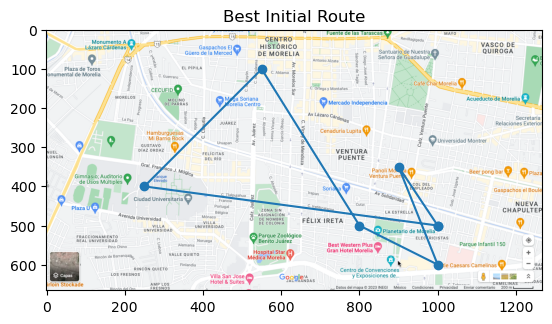

Current gen 0
current best : 2116.51739298696
Current gen 1
current best : 1917.2816879621857
Current gen 2
current best : 1917.2816879621857
Current gen 3
current best : 1917.2816879621857
Final distance: 1917.2816879621857


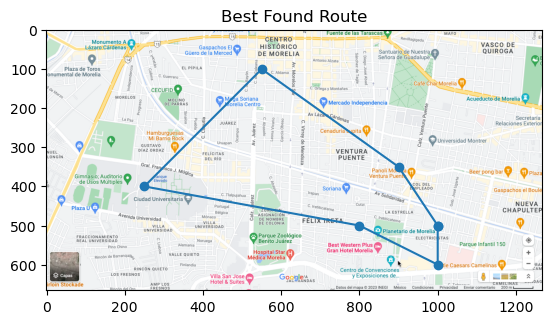

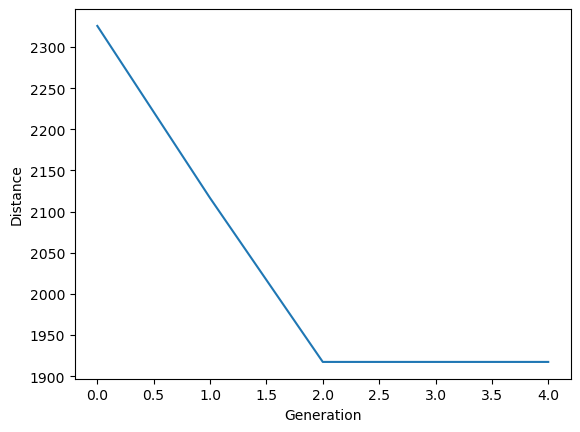

[(1000,500),
 (1000,600),
 (800,500),
 (250,400),
 (550,100),
 (900,350),
 (1000,500)]

In [32]:
img = plt.imread("map.png")

plt.imshow(img)
x = np.array(range(1000))



dailyRoute = [] 
dailyRoute.append(City(1000, 500))
dailyRoute.append(City(250, 400))
dailyRoute.append(City(1000, 600))
dailyRoute.append(City(900, 350))
dailyRoute.append(City(550, 100))
dailyRoute.append(City(800, 500))


def plotRoute(bestRoute, title=""):
    bestRoute.append(bestRoute[0])
    bestRoute = np.array([list([i.x, i.y])for i in bestRoute])

    # plot best initial route
    img = plt.imread("map.png")
    plt.imshow(img)

    plt.plot(bestRoute[:, 0], bestRoute[:, 1], marker='o')
    plt.title(title)
    plt.show()

geneticAlgorithm(population=dailyRoute, popSize=10,
                 eliteSize=5, generations=4)